# Showcasing pcrglobwb_utils

This notebook should provide a first impression on what the pcrglobwb_utils package and the functions therein can contribute to evaluating PCR-GLOBWB runs and output.

## Preparation

### Load packages

In [1]:
import pcrglobwb_utils
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import spotpy as sp
import os, sys
import datetime

In [2]:
print('this notebook was created using Python', str((sys.version)), 'on a', str(sys.platform),'on', datetime.datetime.now())

this notebook was created using Python 3.8.2 | packaged by conda-forge | (default, Mar  5 2020, 17:29:01) [MSC v.1916 64 bit (AMD64)] on a win32 on 2020-05-25 13:54:48.679230


In [3]:
print('using pcrglobwb_utils version', pcrglobwb_utils.__version__)

using pcrglobwb_utils version 0.1.4.3


### specify paths to input files

In [4]:
# nc file of discharge in Amazon basin
ncf = r'example_data/DUMMY_discharge_dailyTot_output.nc'

In [5]:
# text file containing meta-data and observed values at specific GRDC station
grdc_fo = 'example_data/3629000_Obidos.day'

In [6]:
# Excel file containing same data as grdc_fo, but without meta-data
excel_fo = 'example_data/Obidos_data.xlsx'

In [7]:
# log file of run in Amazon basin
log_fo = 'example_data/setup_30min_Amazon_2005_2010_para.log'

### specify variable names

In [8]:
# specifying variable names to be used in column headers and plotting
new_var_name_sim = 'Q$sim$ PCR-GLOBWB [m3/s]'
new_var_name_obs = 'Q$obs$ GRDC [m3/s]'

## get information about GRDC station and its location

In [9]:
# create object from GRDC file
grdc_obj = pcrglobwb_utils.obs_data.grdc_data(grdc_fo)

In [10]:
# get a simple plot_title and properties of GRDC station
plot_title, props = grdc_obj.get_grdc_station_properties()
print(props)

{'station': 'OBIDOS - PORTO', 'latitude': -1.9472, 'longitude': -55.5111}


In [11]:
# based on lon/lat information of GRDC station, find corresponding row/col indices in nc-file
row, col = pcrglobwb_utils.utils.find_indices_from_coords(ncf, props['longitude'], props['latitude'])
print(row, col)

17 50


<Figure size 432x288 with 0 Axes>

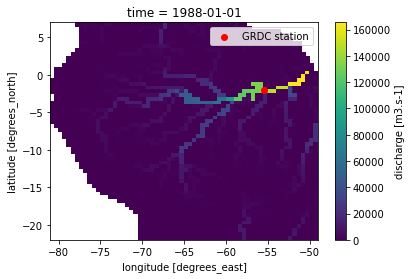

In [12]:
# for visualization purposed, it is also possible to plot variable from nc-file for given data
# and also location of GRDC station on the map
plt.figure()
pcrglobwb_utils.plotting.plot_var_at_timestep(ncf, var_name='discharge', time='1988-01-01')
plt.scatter(props['longitude'], props['latitude'], c='r', label='GRDC station')
plt.legend();

## Reading values files and visualzing them

### From GRDC file

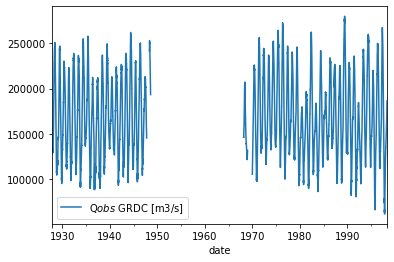

In [13]:
# reading values from GRDC station text file and providing a variable name
df_GRDC = grdc_obj.get_grdc_station_values(var_name=new_var_name_obs, plot=True)

### From Excel file

If the file is not structured like GRDC files but an Excel-file with one sheet containing two columns (date and value), we could do the same by reading from a non-GRDC formatted Excel-file.

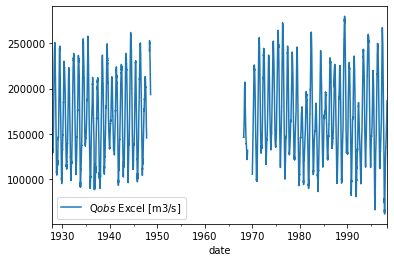

In [15]:
# first, create object 
excel_obj = pcrglobwb_utils.obs_data.other_data(excel_fo)
# second, apply method
df_excel = excel_obj.get_values_from_excel(var_name='Q$obs$ Excel [m3/s]',
                                     plot=True,
                                     remove_mv=True)

### From nc-file

In [ ]:
# create object first
nc_object = pcrglobwb_utils.sim_data.from_nc(ncf)

In [ ]:
# apply method to read values at specific row and col
q_sim_obidos = nc_object.read_values_at_indices(row, col, plot_var_name=new_var_name_sim, plot=True)

In [ ]:
plt.figure()
q_sim_obidos.plot()
df_GRDC[new_var_name_obs].plot(figsize=(20,10))
plt.legend()
plt.title('daily values');

## monthly averaging

It is also possible to compute the monthly averages of the entire timeseries

In [ ]:
GRDC_monthly = pcrglobwb_utils.time_funcs.calc_montly_avg(df_GRDC)

In [ ]:
q_sim_obidos_monthly = pcrglobwb_utils.time_funcs.calc_montly_avg(q_sim_obidos, var_name=new_var_name_sim)

In [ ]:
plt.figure()
ax = q_sim_obidos_monthly.plot()
GRDC_monthly.plot(ax=ax, figsize=(20,10))
plt.legend()
plt.title('long-term monthly averages')
plt.xlabel('month');

## Validation of daily values

In [ ]:
# validating simulations with observations for common time period
df_eval, eval_dic = nc_object.validate_results(df_GRDC, out_dir='./_OUT')
eval_dic

In [ ]:
stats = nc_object.calc_stats(plot=True)
stats

## Aggregating and averaging over time

Sometimes it is handy to resample the daily values to monthly or yearly timeseries.

This can either be done by aggregating them per month/year or calculating the monthly/annual average.

### Aggregating

In [ ]:
monthlyAggrData = pcrglobwb_utils.time_funcs.daily2monthly(q_sim_obidos, averaging=False, plot=True)

In [ ]:
annualAggrData = pcrglobwb_utils.time_funcs.daily2yearly(q_sim_obidos, averaging=False, plot=True)

The unit here is still in m3/s, but sometimes one may be interested in m3 only (or volume in general).

Note that the legend is not updated automatically, this should be done by the user with pandas.rename().

In [ ]:
annualAggrVolData = pcrglobwb_utils.time_funcs.daily2yearly(q_sim_obidos, volumetric=True, plot=True)

### Averaging

In [ ]:
monthlyAvgData = pcrglobwb_utils.time_funcs.daily2monthly(q_sim_obidos, averaging=True, volumetric=False, plot=True)

## Water Balance

By parsing the water balance statements in the log file, it is possible to get the annual values of different water balance components.

In [ ]:
# first, create a water balance object based on the log-file
wb = pcrglobwb_utils.water_balance.water_balance(log_fo)

In [ ]:
# now get annual values of the components
wb.get_annual_values()

In [ ]:
# it is also possible to directly plot them as bar plot
wb.bar_plot()

In [ ]:
# alternatively, the dataframe can be retrieved and all pandas plotting options are available
wb_vals = wb.get_annual_values()
wb_vals.plot(x='year')

## Ensembles

If more than one run is performed but an ensemble (e.g. with different RCPs), it can be useful to automatically compute and vizualize the mean, max, and min of the ensemble.

Since we only have output from one run here, we compute some dummy time series first:

In [ ]:
fact_arr = np.random.rand(4)

In [ ]:
q_ens = [q_sim_obidos]
for factor in fact_arr:
    q_temp = q_sim_obidos.mul(factor)
    q_temp = q_temp.rename(columns={new_var_name_sim: str(factor)})
    q_ens.append(q_temp)

In [ ]:
ens_obj = pcrglobwb_utils.sim_data.ensembles(q_ens[0], q_ens[1], q_ens[2], q_ens[3], q_ens[4])

In [ ]:
df_ens = ens_obj.calc_stats()
df_ens.head()

In [ ]:
ens_obj.plot_bounds()

In [ ]:
df_ens_monthAvg = ens_obj.monthly_avgs(plot=True)